
# **Importing Libraries**

In [56]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import svm
import numpy as np
from pycaret import regression
from pycaret.regression import*
import matplotlib.pyplot as plt
import plotly.express as px
import warnings

   # **Importing the Dataset**

In [57]:
df = pd.read_csv("C:\\Users\\piyus\\Desktop\\Sentiment Analysis\\Tweets_dataset_raw.csv")

# **Basic Dataset go-through**

In [58]:
df.head()

,Text,Language,Label
0,@Charlie_Corley @Kristine1G @amyklobuchar @Sty...,en,litigious
1,#BadBunny: Como dos gotas de agua: Joven se di...,es,negative
2,https://t.co/YJNiO0p1JV Flagstar Bank disclose...,en,litigious
3,Rwanda is set to host the headquarters of Unit...,en,positive
4,OOPS. I typed her name incorrectly (today’s br...,en,litigious


In [59]:
df.shape

(937854, 3)

In [60]:
df.isnull().sum()

Text         0
Language    23
Label        0
dtype: int64

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 937854 entries, 0 to 937853
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   Text      937854 non-null  object
 1   Language  937831 non-null  object
 2   Label     937854 non-null  object
dtypes: object(3)
memory usage: 21.5+ MB


In [62]:
df.duplicated().sum()

4974

In [63]:
print(df['Text'][:20]) #there a lot of garbage information in the data like, hastags, @mentions, emojis and web links.

0     @Charlie_Corley @Kristine1G @amyklobuchar @Sty...
1     #BadBunny: Como dos gotas de agua: Joven se di...
2     https://t.co/YJNiO0p1JV Flagstar Bank disclose...
3     Rwanda is set to host the headquarters of Unit...
4     OOPS. I typed her name incorrectly (today’s br...
5     It sucks for me since I'm focused on the natur...
6     @en_font Treballar a l’obra a partir dels 19 a...
7     @ShawnTarloff @itsmieu you can also relate thi...
8     Social Security. Constant political crises dis...
9     @FilmThePoliceLA A broken rib can puncture a l...
10    @jacobringenwald @aKeithWatts @CountDankulaTV ...
11    @NZ_HK_SU @telebusiness My question was rhetor...
12    Wimbledon: Nick Kyrgios admits spitting toward...
13    is booktwt a thing? if so thats her and she sp...
14    @SaltBurned [When the first sign of surrender ...
15    @co_fuckoff J'espere que ça passera le plus vi...
16    @roipaee @joe98100959 @Formula1game @redbullra...
17    🤩 Power back on (1855749):  North VI in La

In [74]:
print(f" Number of rows containing http is : {len(df[df['Text'].str.contains('http')])}")
print(f" Number of rows containing # is : {len(df[df['Text'].str.contains('#')])}")
print(f" Number of rows containing @ is : {len(df[df['Text'].str.contains('@')])}")
print(f" Number of rows containing www is : {len(df[df['Text'].str.contains('www')])}")
print(f" Number of rows containing ! is : {len(df[df['Text'].str.contains('!')])}")
print(f" Number of rows containing ? is : {len(df[df['Text'].str.contains('%')])}")

 Number of rows containing http is : 268079
 Number of rows containing # is : 115977
 Number of rows containing @ is : 572843
 Number of rows containing www is : 774
 Number of rows containing ! is : 125859
 Number of rows containing ? is : 10916


# **Checking the distribution of Data**

In [64]:
df.reset_index(drop=True, inplace = True)

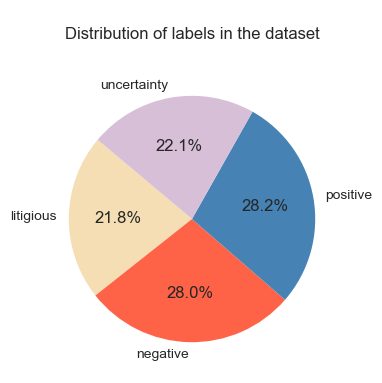

In [76]:
labels = df.groupby(df['Label']).size().index
values = df.groupby(df['Label']).size().values

plt.figure(figsize=(4, 4))
plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=140, colors = ['wheat','tomato','steelblue','thistle'])
plt.title('\nDistribution of labels in the dataset\n')

plt.show()

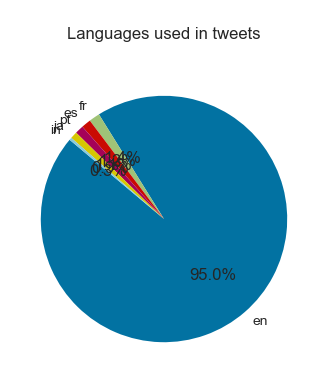

In [71]:
labels = df.groupby(df['Language']).size().sort_values(ascending=False).index[0:6]
values = df.groupby(df['Language']).size().sort_values(ascending=False).values[0:6]

plt.figure(figsize=(4, 4))
plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('\nLanguages used in tweets\n')

plt.show()

In [72]:
#we can see that the data is majorly in english language

# Cleaning the Data

In [80]:
# # This Function for converting texts to lower case
# def lower_case(x):
#     for index, row in x.iterrows():
#         x.at[index, 'Text'] = row['Text'].lower()
#     return x

# # Function to remove URLs
# def remove_url(x):
#     for index, row in x.iterrows():
#         x.at[index, 'Text'] = re.sub(r'http\S+|www\S+', '', row['Text'])
#     return x

# # Function to remove # and @ symbols
# def remove_symbols(x):
#     for index, row in x.iterrows():
#         x.at[index, 'Text'] = re.sub('[@#]\S+', '', row['Text'])
#     return x

# # Function to remove punctuation
# def remove_punc(x):
#     for index, row in x.iterrows():
#         x.at[index, 'Text'] = re.sub('[()!?:*;-^\n]', '', row['Text'])
#     return x

# # Function to remove digits
# def remove_digits(x):
#     for index, row in x.iterrows():
#         x.at[index, 'Text'] = re.sub('\d', '', row['Text'])
#     return x

lower_case= lambda x: x['Text'].str.lower() # To convert all the text to lowercase letters
remove_url=lambda x: x['Text'].str.replace(r'http\S+|www\S+','') # To remove URL's
remove_symbols= lambda x:x['Text'].str.replace('[@,#]\S+','')    # To remove # and @ symbols frequently used in tweets
remove_punc=lambda x:x['Text'].str.replace('[()!?:*;-^\n]','')   # To further remove symbols which not gonna be use further
remove_digits=lambda x:x['Text'].str.replace('\d','')            # To remove any digits



In [81]:
#implementing all of the above functions using another function, so that we can do this in one go.
def clean_data(df):
    
    df['Text']=lower_case(df)
    df['Text']=remove_url(df)
    df['Text']=remove_symbols(df)
    df['Text']=remove_punc(df)
    df['Text']=remove_digits(df)
    df=df.astype(str).apply(lambda x: x.str.encode('ascii', 'ignore').str.decode('ascii'))
    df['Text']=df['Text'].str.strip() # To strip off white spaces
    rm_index=df[df["Text"].str.contains("[a-z]")==False].index # There were some text like \n\n... I did this to remove them
    df=df.drop(rm_index)
    return df

In [82]:
df_cleaned = clean_data(df)

In [88]:
df_cleaned.head(20)

,Text,Language,Label
0,"testimony is not evidence in a court of law, s...",en,litigious
1,como dos gotas de agua joven se disfraza de ba...,es,negative
2,flagstar bank discloses a data breach that imp...,en,litigious
3,rwanda is set to host the headquarters of unit...,en,positive
4,oops. i typed her name incorrectly todays brav...,en,litigious
5,it sucks for me since i'm focused on the natur...,en,negative
6,treballar a lobra a partir dels anys fins als...,ca,negative
7,you can also relate this to art too a lot of p...,en,uncertainty
8,social security. constant political crises dis...,en,negative
9,a broken rib can puncture a lung or lead to a ...,en,negative


In [85]:
df_cleaned.duplicated().sum()

51271

In [86]:
#the dataset have a lot of duplicate entries, we need to clear them

df_cleaned.drop_duplicates(inplace=True)

In [87]:
df_cleaned.duplicated().sum()

0

# Training Model

In [90]:
df = df_cleaned
# Prepare the data
df.drop('Language', inplace = True, axis = 1)
df.columns=['text', 'sentiment']
X = df['text']
y = df['sentiment']



In [91]:
df.head()

,text,sentiment
0,"testimony is not evidence in a court of law, s...",litigious
1,como dos gotas de agua joven se disfraza de ba...,negative
2,flagstar bank discloses a data breach that imp...,litigious
3,rwanda is set to host the headquarters of unit...,positive
4,oops. i typed her name incorrectly todays brav...,litigious
